# Data exploration and preprocessing

## Import matplotlib

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

## Import pandas, Sklearn & tensorflow

In [2]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

## Data import

In [3]:
df_game_events = pd.read_csv("../data/game_events.csv")
print("Columns in game_events:")
print(df_game_events.columns.tolist())
print("\n")

df_game_metadata = pd.read_csv("../data/game_metadata.csv")
print("Columns in game_metadata:")
print(df_game_metadata.columns.tolist())
print("\n")

df_game_players_stats = pd.read_csv("../data/game_players_stats.csv")
print("Columns in game_players_stats:")
print(df_game_players_stats.columns.tolist())

Columns in game_events:
['id', 'game_id', 'timestamp', 'event_type', 'killer_id', 'killed_id', 'assisting_player_ids', 'drake_type']


Columns in game_metadata:
['game_id', 'date', 'match_id', 'tournament_id', 'tournament_name', 'series_id', 'series_name', 'league_id', 'league_name']


Columns in game_players_stats:
['game_id', 'player_id', 'player_name', 'team_id', 'team_name', 'team_acronym', 'role', 'win', 'game_length', 'champion_name', 'team_kills', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 'player_kills', 'player_deaths', 'player_assists', 'total_minions_killed', 'gold_earned', 'level', 'total_damage_dealt', 'total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 'largest_killing_spree', 'largest_multi_kill']


### Features in game_events usefull for the player classification

In [4]:
game_events_features = ['timestamp', 'event_type', 'killer_id', 'killed_id']

game_players_stats_features = ['game_length', 'champion_name', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 
                               'player_kills', 'player_deaths', 'player_assists','total_minions_killed', 'gold_earned', 'level', 
                               'total_damage_dealt','total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                               'largest_killing_spree', 'largest_multi_kill']

## Final features used for player classification

In [5]:
game_players_input_features = ['KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm',
                            'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm',
                            'greatest_killing_spree', 'greatest_multi_kill']

## Check for missing values

In [6]:
# Check for missing values in game_players_stats_features
print("Missing values count in game_players_stats_features:")
for column in game_players_stats_features:
    missing = df_game_players_stats[column].isna().sum()
    if missing > 0:
        print(f"- {column}: {missing} missing values ({missing/len(df_game_players_stats):.2%})")
        
# Check for missing values in game_events_features
print("Missing values count in game_events_features:")
for column in game_events_features:
    missing = df_game_events[column].isna().sum()
    if missing > 0:
        print(f"- {column}: {missing} missing values ({missing/len(df_game_events):.2%})")

Missing values count in game_players_stats_features:
Missing values count in game_events_features:
- killer_id: 137338 missing values (7.29%)
- killed_id: 842221 missing values (44.69%)


## Explore events with and without Killer ID

<Figure size 1400x800 with 0 Axes>

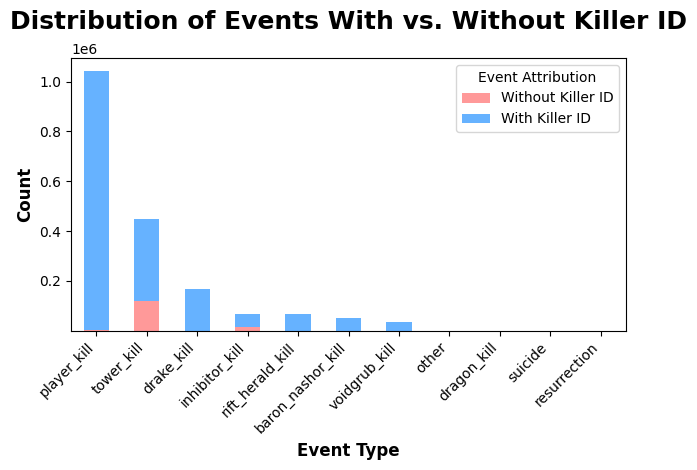

Percentage of each event type occurring without killer_id:
player_kill: 0.20% without killer ID (2129 out of 1042510 events)
tower_kill: 26.52% without killer ID (119158 out of 449292 events)
drake_kill: 0.00% without killer ID (7 out of 169112 events)
inhibitor_kill: 22.20% without killer ID (15301 out of 68934 events)
rift_herald_kill: 1.09% without killer ID (729 out of 66798 events)
baron_nashor_kill: 0.00% without killer ID (1 out of 51947 events)
voidgrub_kill: 0.00% without killer ID (0 out of 35855 events)
other: 0.00% without killer ID (0 out of 252 events)
dragon_kill: 0.00% without killer ID (0 out of 26 events)
suicide: 100.00% without killer ID (13 out of 13 events)
resurrection: 0.00% without killer ID (0 out of 1 events)


In [7]:
# Filter events with and without killer_id
events_without_killer = df_game_events[df_game_events['killer_id'].isna()]
events_with_killer = df_game_events[~df_game_events['killer_id'].isna()]

# Count occurrences of each event type
without_killer_counts = events_without_killer['event_type'].value_counts()
with_killer_counts = events_with_killer['event_type'].value_counts()

# Combine both series into a DataFrame for easier plotting
event_data = pd.DataFrame({
    'Without Killer ID': without_killer_counts,
    'With Killer ID': with_killer_counts
}).fillna(0)

# Sort by total events to make visualization clearer
event_data['Total'] = event_data.sum(axis=1)
event_data = event_data.sort_values('Total', ascending=False)
event_data = event_data.drop('Total', axis=1)

# Create the stacked bar graph
plt.figure(figsize=(14, 8))
event_data.plot(kind='bar', stacked=True, 
                color=['#FF9999', '#66B2FF'])  # Light red for without, blue for with

plt.title("Distribution of Events With vs. Without Killer ID")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Event Attribution")
plt.tight_layout()
plt.show()

# Print percentages for each event type
print("Percentage of each event type occurring without killer_id:")
for event_type in event_data.index:
    with_killer = event_data.loc[event_type, 'With Killer ID']
    without_killer = event_data.loc[event_type, 'Without Killer ID']
    total = with_killer + without_killer
    percentage = (without_killer / total) * 100 if total > 0 else 0
    print(f"{event_type}: {percentage:.2f}% without killer ID ({without_killer:.0f} out of {total:.0f} events)")

## Explore events with and without Killed ID

<Figure size 1400x800 with 0 Axes>

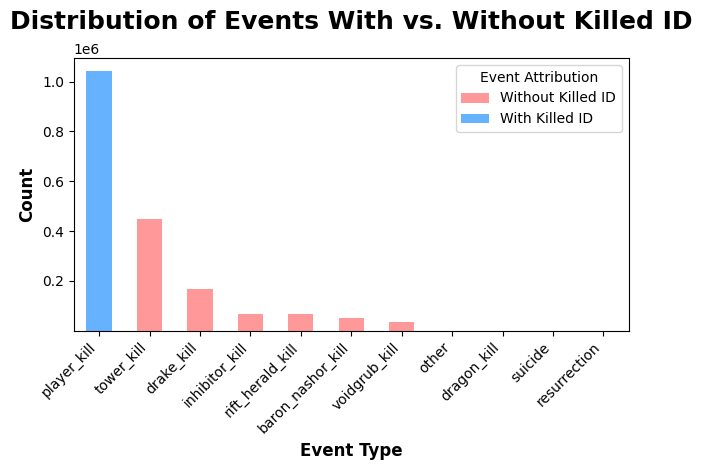

Percentage of each event type occurring without killed_id:
player_kill: 0.00% without killer ID (0 out of 1042510 events)
tower_kill: 100.00% without killer ID (0 out of 449292 events)
drake_kill: 100.00% without killer ID (0 out of 169112 events)
inhibitor_kill: 100.00% without killer ID (0 out of 68934 events)
rift_herald_kill: 100.00% without killer ID (0 out of 66798 events)
baron_nashor_kill: 100.00% without killer ID (0 out of 51947 events)
voidgrub_kill: 100.00% without killer ID (0 out of 35855 events)
other: 100.00% without killer ID (0 out of 252 events)
dragon_kill: 100.00% without killer ID (0 out of 26 events)
suicide: 0.00% without killer ID (0 out of 13 events)
resurrection: 0.00% without killer ID (0 out of 1 events)


In [8]:
# Filter events with and without killer_id
events_without_killed = df_game_events[df_game_events['killed_id'].isna()]
events_with_killed = df_game_events[~df_game_events['killed_id'].isna()]

# Count occurrences of each event type
without_killed_counts = events_without_killed['event_type'].value_counts()
with_killed_counts = events_with_killed['event_type'].value_counts()

# Combine both series into a DataFrame for easier plotting
event_data = pd.DataFrame({
    'Without Killed ID': without_killed_counts,
    'With Killed ID': with_killed_counts
}).fillna(0)

# Sort by total events to make visualization clearer
event_data['Total'] = event_data.sum(axis=1)
event_data = event_data.sort_values('Total', ascending=False)
event_data = event_data.drop('Total', axis=1)

# Create the stacked bar graph
plt.figure(figsize=(14, 8))
event_data.plot(kind='bar', stacked=True, 
                color=['#FF9999', '#66B2FF'])  # Light red for without, blue for with

plt.title("Distribution of Events With vs. Without Killed ID")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Event Attribution")
plt.tight_layout()
plt.show()

# Print percentages for each event type
print("Percentage of each event type occurring without killed_id:")
for event_type in event_data.index:
    with_killed = event_data.loc[event_type, 'With Killed ID']
    without_killed = event_data.loc[event_type, 'Without Killed ID']
    total = with_killed + without_killed
    percentage = (without_killed / total) * 100 if total > 0 else 0
    print(f"{event_type}: {percentage:.2f}% without killer ID ({without_killer:.0f} out of {total:.0f} events)")

## Explore game statistics

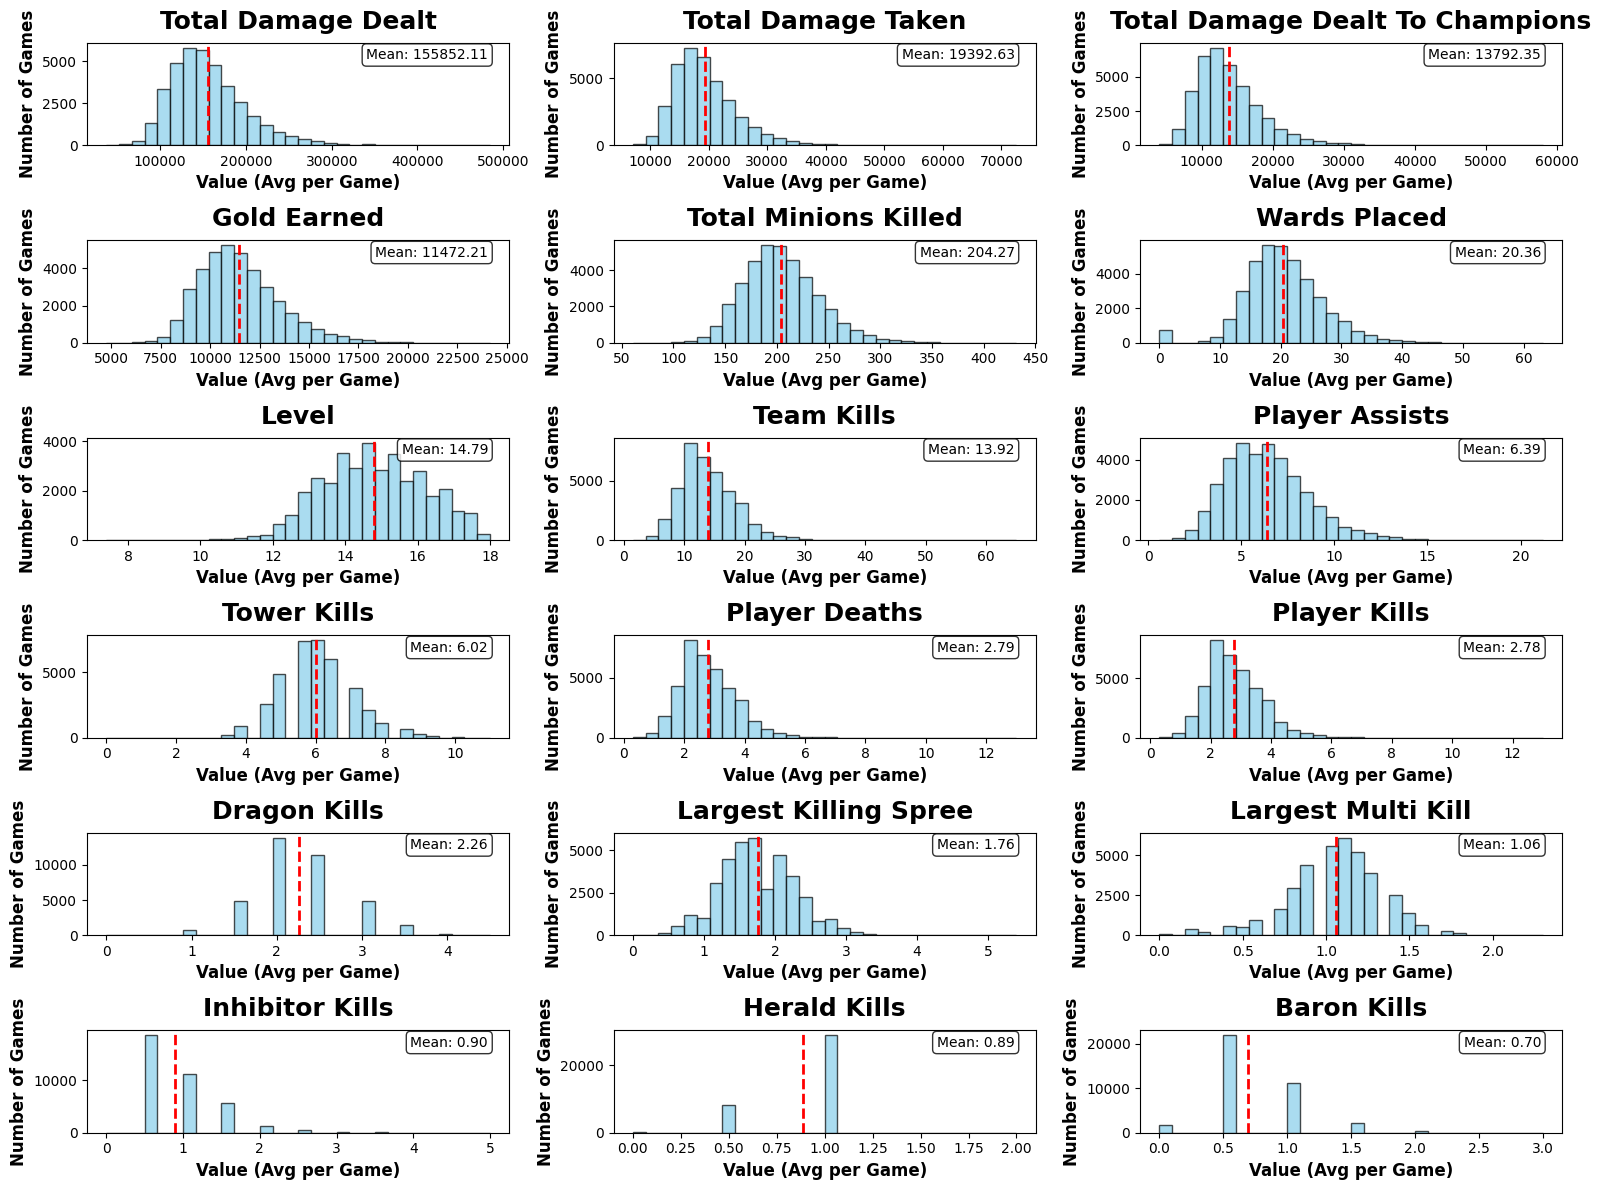

Summary Statistics for Game-Level Averages:
                                          Mean    Median       Std Dev  \
baron_kills                           0.696327       0.5      0.356471   
dragon_kills                          2.262706       2.0      0.552995   
gold_earned                       11472.210042   11222.6   2006.226089   
herald_kills                          0.885926       1.0      0.212971   
inhibitor_kills                       0.895261       1.0      0.497097   
largest_killing_spree                 1.762380       1.7      0.516371   
largest_multi_kill                    1.059989       1.1      0.281432   
level                                14.789689      14.8      1.403444   
player_assists                        6.393856       6.1      2.206882   
player_deaths                         2.788650       2.7      0.910648   
player_kills                          2.783022       2.7      0.909023   
team_kills                           13.915079      13.5      4.5451

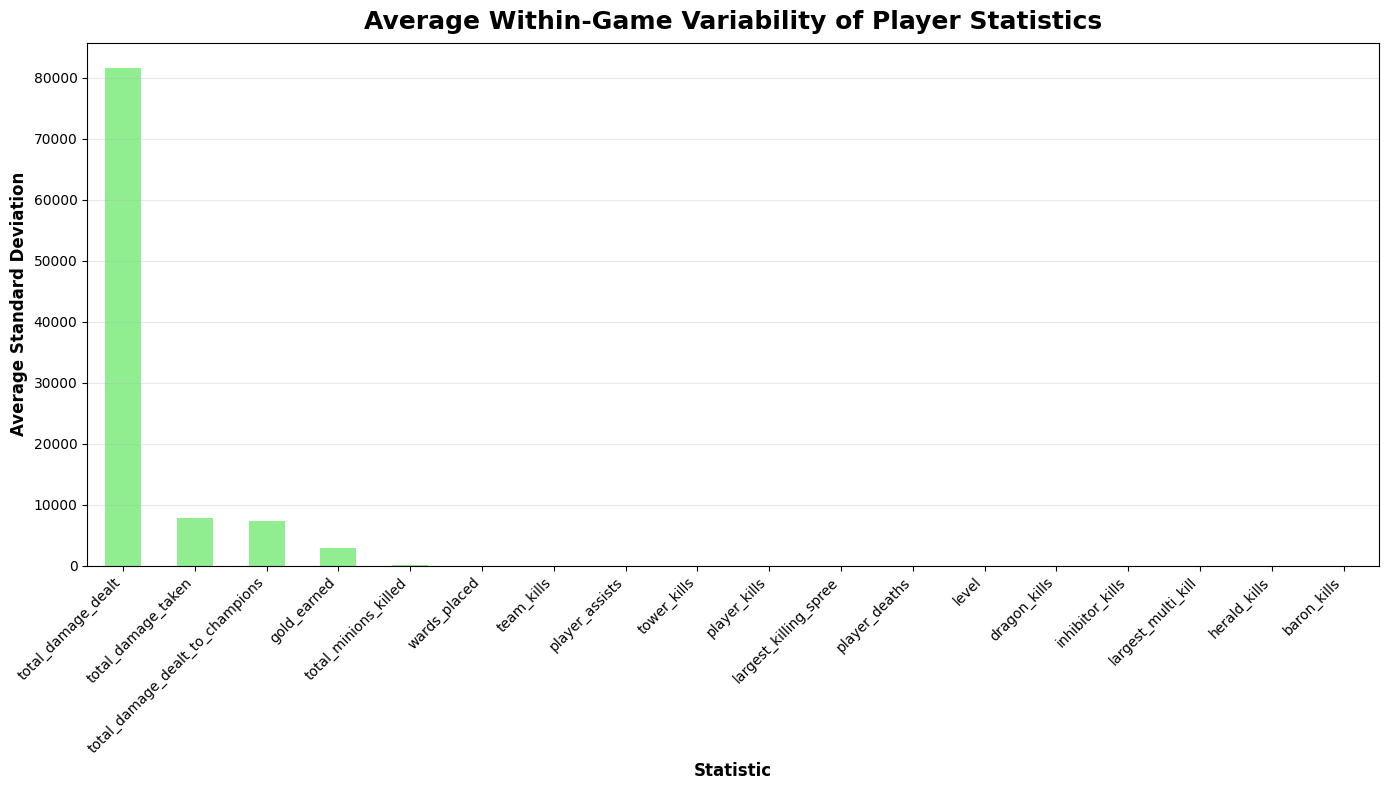

In [9]:
# Explore average values of game player stats grouped by games

# Select numeric columns only for analysis
numeric_columns = df_game_players_stats.select_dtypes(include=['number']).columns.tolist()

numeric_columns = [col for col in numeric_columns if col not in ['game_id', 'game_length', 'champion_name', 'player_id', 'team_id']]

# Group by game_id and calculate means for each game
game_means = df_game_players_stats.groupby('game_id')[numeric_columns].mean()

# Calculate overall means of the game means
mean_values = game_means.mean().sort_values(ascending=False)

# Create a figure with multiple subplots, one for each feature
plt.figure(figsize=(16, 12))

# Number of columns in the grid
n_cols = 3
n_rows = (len(mean_values) + n_cols - 1) // n_cols  # Ceiling division

for i, (column, mean_val) in enumerate(mean_values.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Get data for this column (the game-grouped means)
    data = game_means[column].dropna()
    
    # Create histogram with appropriate bins
    plt.hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add a vertical line for the mean of means
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
    
    # Add text annotation for mean value
    plt.text(0.95, 0.95, f'Mean: {mean_val:.2f}', 
             transform=plt.gca().transAxes, 
             ha='right', va='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Set titles and labels
    plt.title(f'{column.replace("_", " ").title()}')
    plt.xlabel('Value (Avg per Game)')
    plt.ylabel('Number of Games')
    
    # Adjust y-scale to log if data has large range
    if data.max() / (data.min() + 1) > 100:  # Add 1 to avoid division by zero
        plt.yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

# Print a summary table of statistics based on game averages
summary_stats = pd.DataFrame({
    'Mean': mean_values,
    'Median': game_means.median(),
    'Std Dev': game_means.std(),
    'Min': game_means.min(),
    'Max': game_means.max()
})

print("Summary Statistics for Game-Level Averages:")
print(summary_stats)

# Additionally, visualize distribution of game statistics variance
# This shows how much player stats vary within each game

# Calculate the standard deviation within each game
game_stds = df_game_players_stats.groupby('game_id')[numeric_columns].std()

# Get mean of standard deviations across games (average variability)
mean_stds = game_stds.mean().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
mean_stds.plot(kind='bar', color='lightgreen')
plt.title('Average Within-Game Variability of Player Statistics')
plt.xlabel('Statistic')
plt.ylabel('Average Standard Deviation')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Check number of game played

Dataset Statistics:
Total number of unique games: 37459
Total number of unique players: 4953

Games per player statistics:
Average games per player: 75.62
Median games per player: 31
Min games per player: 1
Max games per player: 710


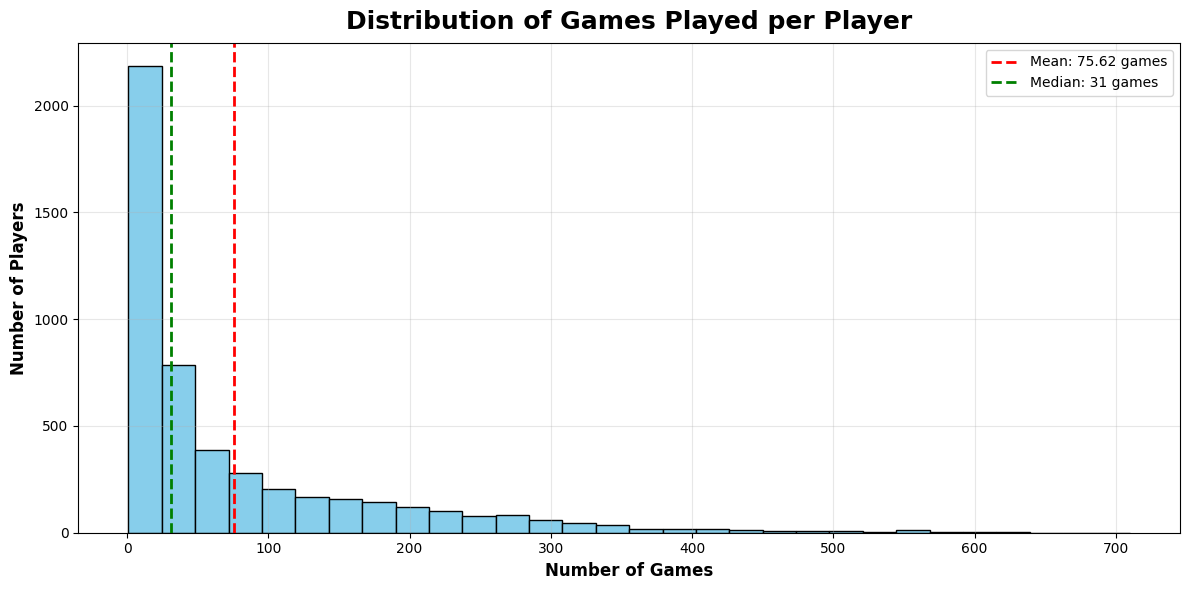


1196 players (24.15%) played less than 10 games


In [10]:
# Check game distribution and number of games played
print("Dataset Statistics:")
print(f"Total number of unique games: {df_game_players_stats['game_id'].nunique()}")
print(f"Total number of unique players: {df_game_players_stats['player_id'].nunique()}")

# Calculate games per player
games_per_player = df_game_players_stats.groupby('player_id')['game_id'].nunique()

print(f"\nGames per player statistics:")
print(f"Average games per player: {games_per_player.mean():.2f}")
print(f"Median games per player: {games_per_player.median():.0f}")
print(f"Min games per player: {games_per_player.min()}")
print(f"Max games per player: {games_per_player.max()}")

# Plot the distribution of games per player
plt.figure(figsize=(12, 6))
plt.hist(games_per_player, bins=30, color='skyblue', edgecolor='black')
plt.axvline(games_per_player.mean(), color='red', linestyle='dashed', linewidth=2,
           label=f'Mean: {games_per_player.mean():.2f} games')
plt.axvline(games_per_player.median(), color='green', linestyle='dashed', linewidth=2,
           label=f'Median: {games_per_player.median():.0f} games')

plt.title("Distribution of Games Played per Player")
plt.xlabel("Number of Games")
plt.ylabel("Number of Players")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate what percentage of players played only 1 game
ten_game_players = (games_per_player < 10).sum()
percentage = (ten_game_players / len(games_per_player)) * 100
print(f"\n{ten_game_players} players ({percentage:.2f}%) played less than 10 games")

## Delete data for players who played less than 5 games

In [11]:
# Get player IDs with less than 5 games
games_per_player = df_game_players_stats.groupby('player_id')['game_id'].nunique()
players_less_than_10_games = games_per_player[games_per_player < 10].index.tolist()

# Count records before filtering
count_before = len(df_game_players_stats)

# Filter out players with less than 5 games
df_game_players_stats_filtered = df_game_players_stats[~df_game_players_stats['player_id'].isin(players_less_than_10_games)]

# Count records after filtering
count_after = len(df_game_players_stats_filtered)
records_removed = count_before - count_after

print(f"Filtered {len(players_less_than_10_games)} players who played less than 10 games")
print(f"Removed {records_removed} records ({records_removed/count_before:.2%} of the dataset)")
print(f"Dataset size before: {count_before} records")
print(f"Dataset size after: {count_after} records")

# Replace original DataFrame with filtered version
df_game_players_stats = df_game_players_stats_filtered

# Check if we need to filter events data too (if you want to apply the same filter to game events)
# This is needed only if you want to keep events data consistent with player stats
if 'player_id' in df_game_events.columns:
    events_before = len(df_game_events)
    df_game_events = df_game_events[~df_game_events['player_id'].isin(players_less_than_10_games)]
    events_after = len(df_game_events)
    print(f"Also removed {events_before - events_after} event records")

Filtered 1196 players who played less than 10 games
Removed 4780 records (1.28% of the dataset)
Dataset size before: 374554 records
Dataset size after: 369774 records


## Champion occurence

<class 'pandas.core.frame.DataFrame'>
Index: 369774 entries, 0 to 374553
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   game_id                          369774 non-null  int64 
 1   player_id                        369774 non-null  int64 
 2   player_name                      369774 non-null  object
 3   team_id                          369774 non-null  int64 
 4   team_name                        369774 non-null  object
 5   team_acronym                     369579 non-null  object
 6   role                             369774 non-null  object
 7   win                              369774 non-null  bool  
 8   game_length                      369774 non-null  int64 
 9   champion_name                    369774 non-null  object
 10  team_kills                       369774 non-null  int64 
 11  tower_kills                      369774 non-null  int64 
 12  inhibitor_kills      

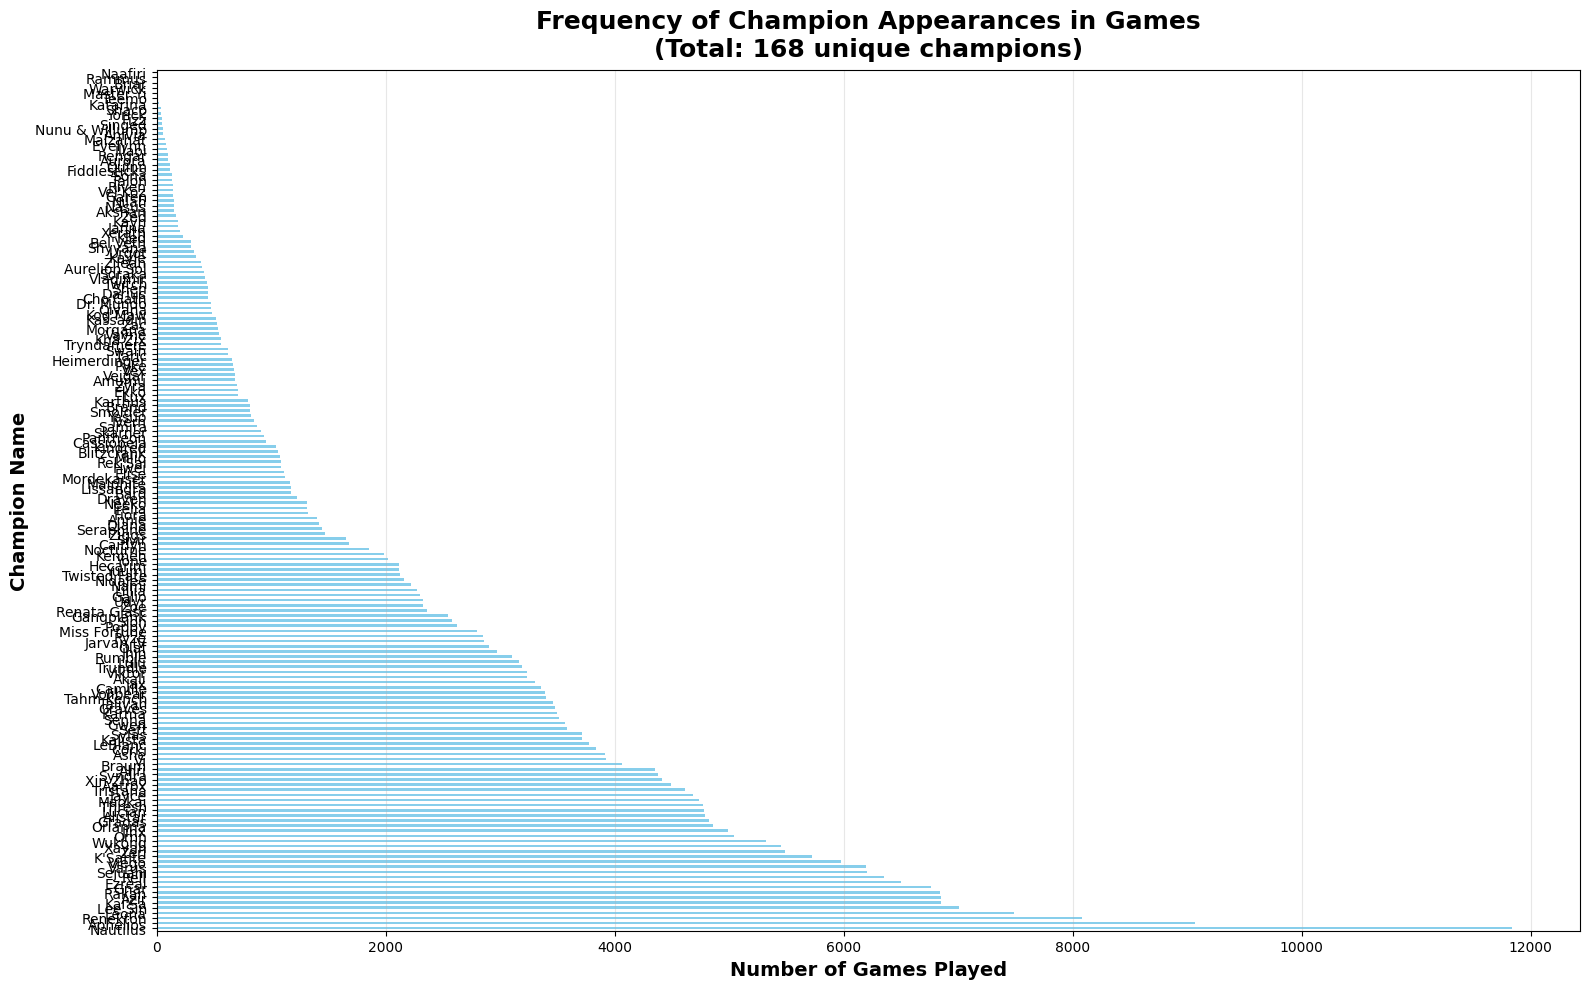

Total number of unique champions: 168
Most popular champion: Nautilus (11838 games)
Least popular champion: Naafiri (6 games)
Average games per champion: 2201.04
Median games per champion: 1269

Rare champions (less than 10 appearances): 2
champion_name
Rammus     7
Naafiri    6
Name: count, dtype: int64


In [12]:
df_game_players_stats_filtered.info()

# Get champion name frequency and sort by count (descending)
champion_counts = df_game_players_stats['champion_name'].value_counts().sort_values(ascending=False)

# Create a figure with appropriate size based on number of champions
plt.figure(figsize=(16, 10))

# Plot horizontal bar chart for better readability with many champions
champion_counts.plot(kind='barh', color='skyblue')

# Add labels and title
plt.title('Frequency of Champion Appearances in Games', fontsize=20)
plt.xlabel('Number of Games Played', fontsize=14)
plt.ylabel('Champion Name', fontsize=14)

# Add grid for easier reading of values
plt.grid(axis='x', alpha=0.3)

# Show total number of unique champions in the plot title
plt.title(f'Frequency of Champion Appearances in Games\n(Total: {len(champion_counts)} unique champions)')

# Improve layout
plt.tight_layout()
plt.show()

# Print some statistics about champion distribution
print(f"Total number of unique champions: {len(champion_counts)}")
print(f"Most popular champion: {champion_counts.index[0]} ({champion_counts.iloc[0]} games)")
print(f"Least popular champion: {champion_counts.index[-1]} ({champion_counts.iloc[-1]} games)")
print(f"Average games per champion: {champion_counts.mean():.2f}")
print(f"Median games per champion: {champion_counts.median():.0f}")

# Show champions with very few appearances (potential outliers)
rare_champions = champion_counts[champion_counts < 10]
if len(rare_champions) > 0:
    print(f"\nRare champions (less than 10 appearances): {len(rare_champions)}")
    print(rare_champions)

C:\Users\arthu\AppData\Local\Temp\ipykernel_31480\3914442129.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


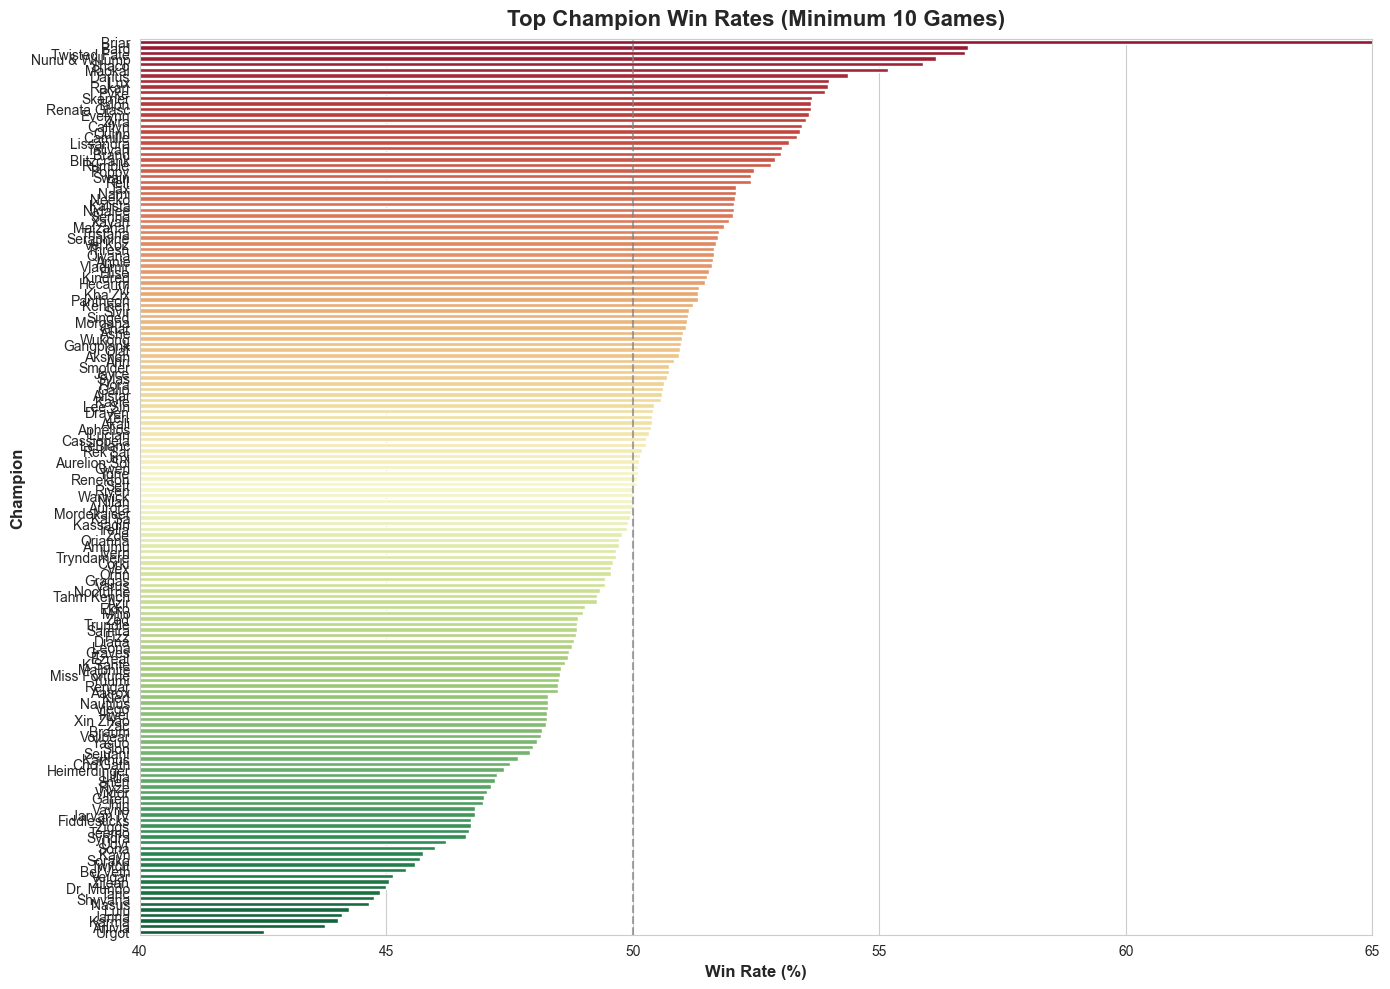

Average champion win rate: 49.44%
Median champion win rate: 50.00%
Win rate standard deviation: 5.16%

Top 10 highest win rate champions:
      champion_name  games_played  win_rate
18            Briar            10     70.00
13             Bard          1192     56.80
138    Twisted Fate          2147     56.73
92   Nunu & Willump            57     56.14
116           Shaco            34     55.88
78           Maokai          4817     55.18
24           Darius           458     54.37
75              Lux           730     53.97
101           Rakan          6904     53.95
98             Pyke           681     53.89

Bottom 10 lowest win rate champions:
    champion_name  games_played  win_rate
48          Janna           195     44.10
57          Karma          3574     44.01
6          Anivia            64     43.75
141         Urgot           334     42.51
67        Kog'Maw           490     41.02
45         Illaoi            88     38.64
155        Xerath           210     38.57
159 

C:\Users\arthu\AppData\Local\Temp\ipykernel_31480\3914442129.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\arthu\AppData\Local\Temp\ipykernel_31480\3914442129.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\arthu\AppData\Local\Temp\ipykernel_31480\3914442129.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\arthu\AppData\Local\Temp\ipykernel_31480\3914442129.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

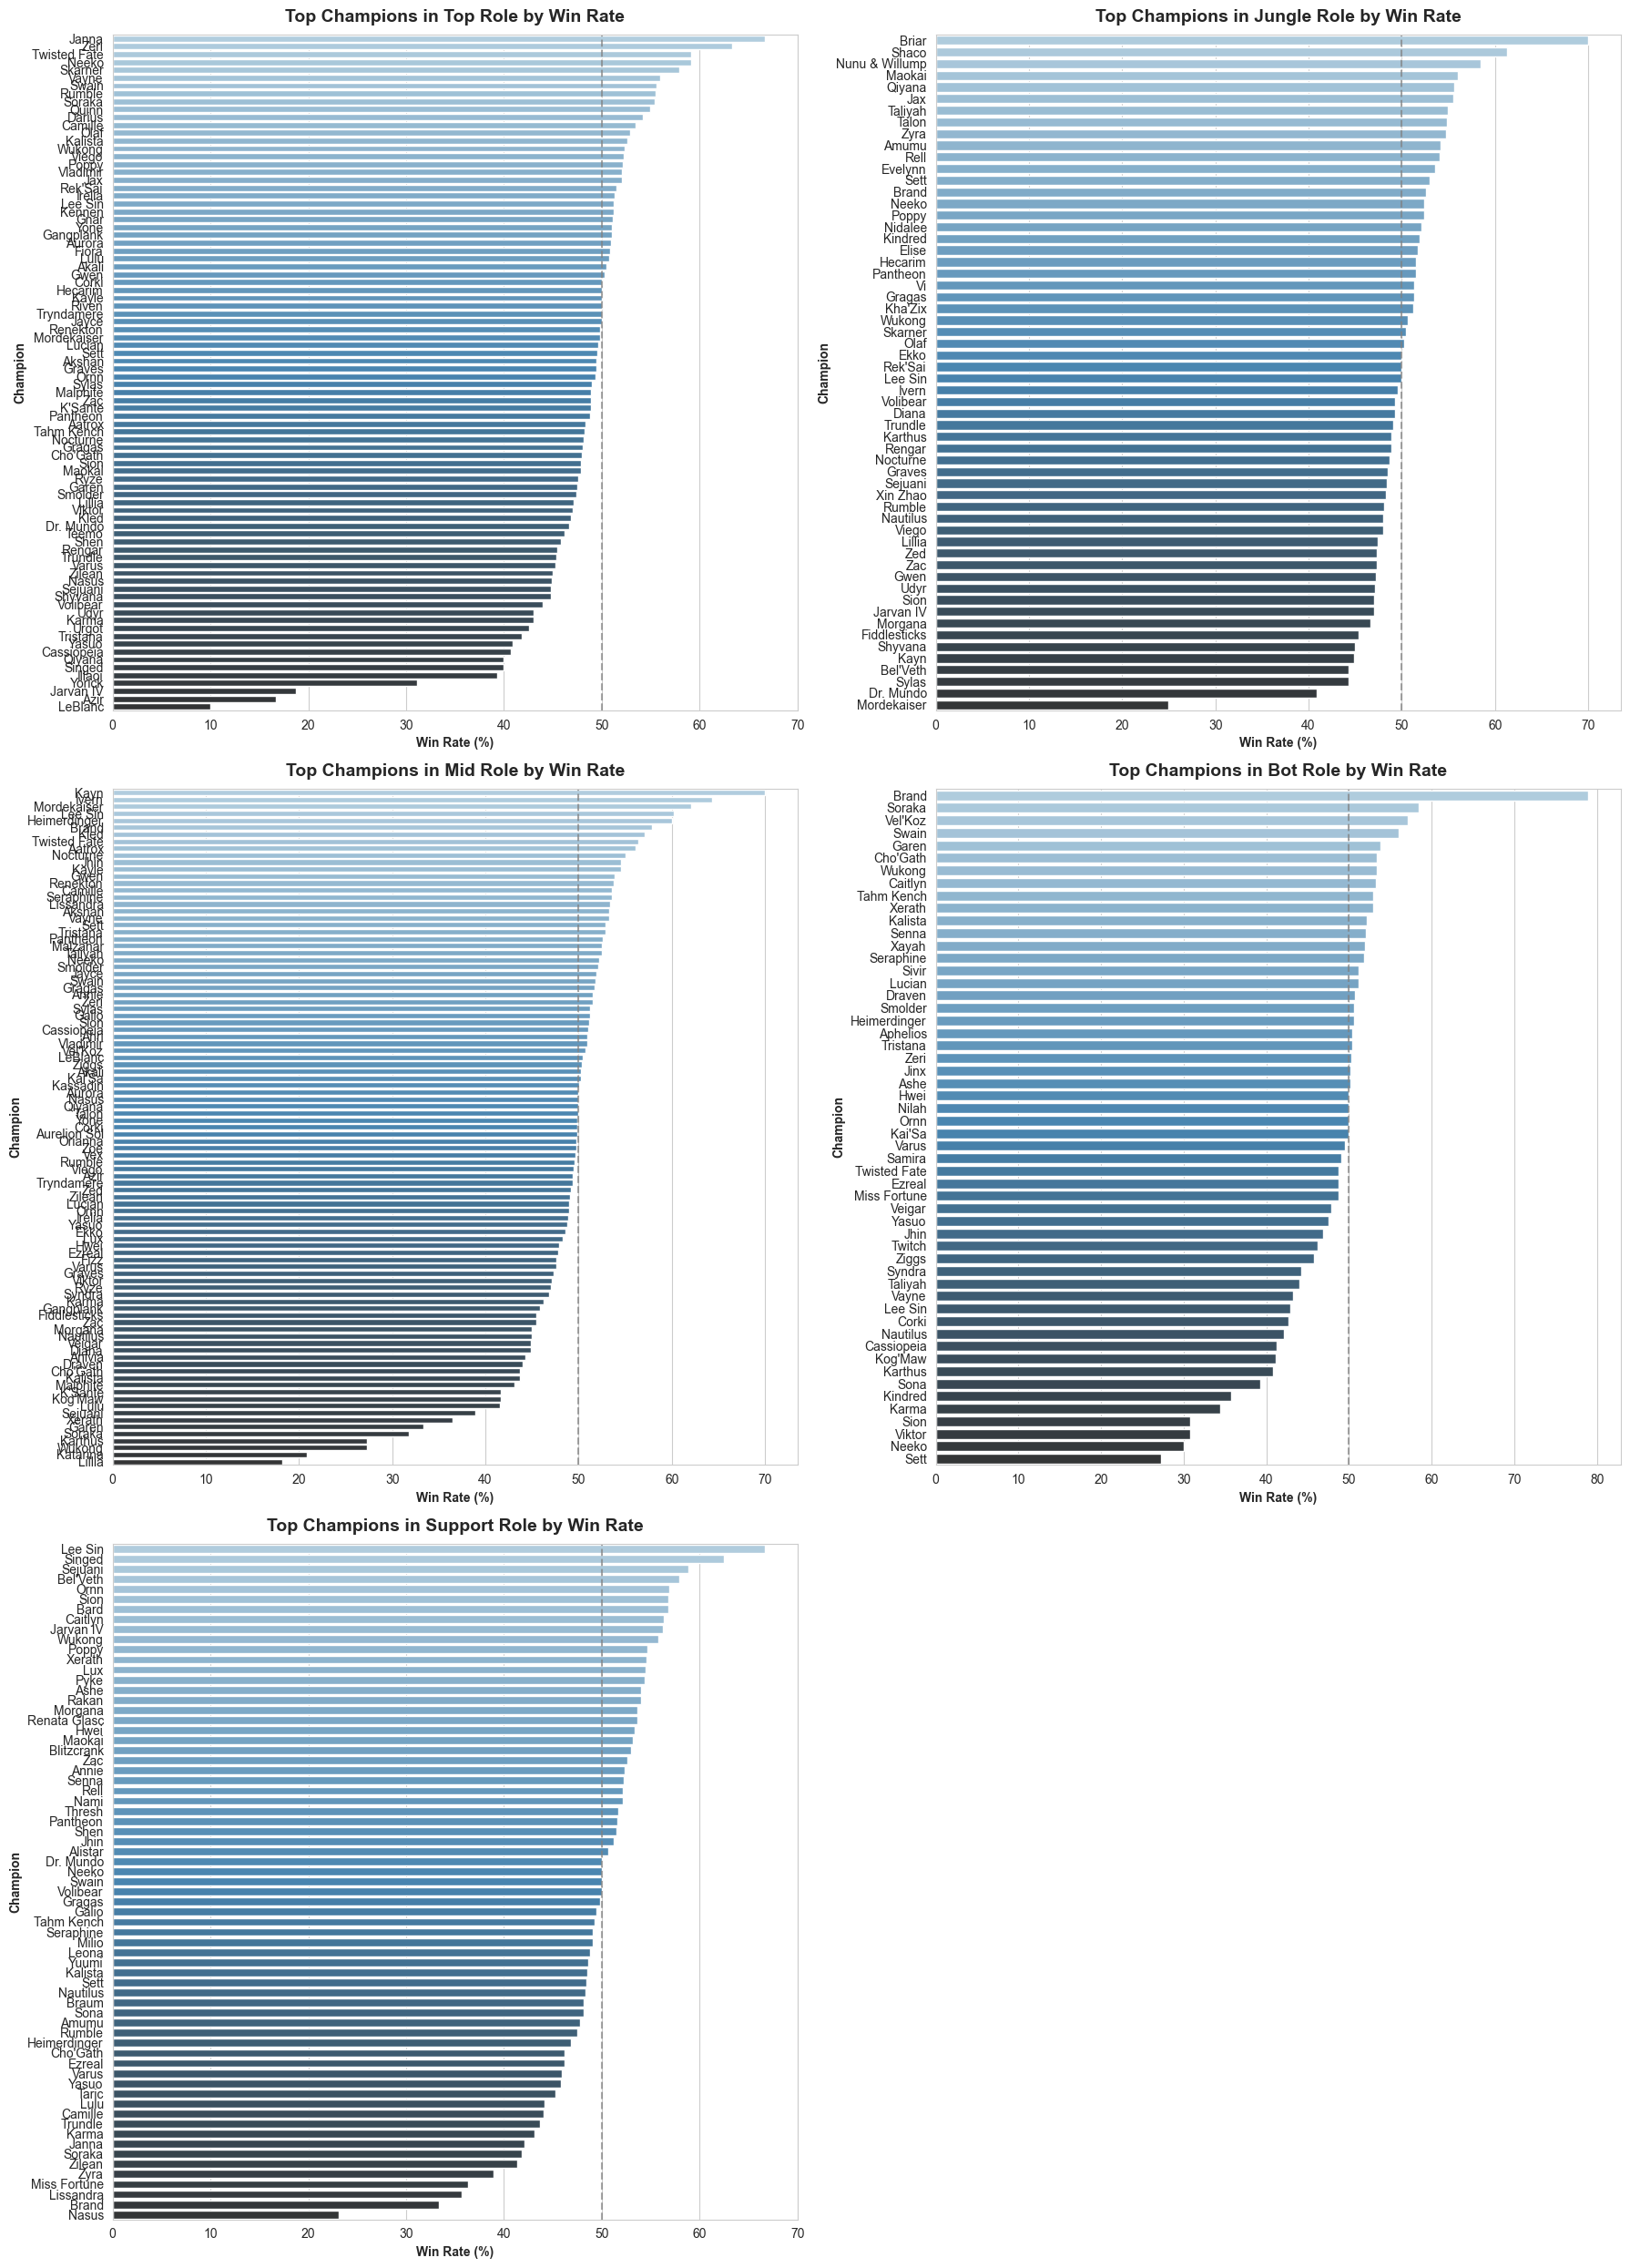

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load player stats data
df_players = pd.read_csv("../data/game_players_stats.csv")

# Calculate overall win rate for each champion (minimum 10 games played)
champion_stats = df_players.groupby('champion_name').agg(
    games_played=('game_id', 'count'),
    wins=('win', 'sum')
).reset_index()

# Calculate win rate percentage
champion_stats['win_rate'] = (champion_stats['wins'] / champion_stats['games_played'] * 100).round(2)

# Filter champions with significant number of games (>= 10)
popular_champions = champion_stats[champion_stats['games_played'] >= 10].sort_values('win_rate', ascending=False)

# Create a visualization
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# Plot win rates with color gradient based on win rate
bars = sns.barplot(
    x='win_rate', 
    y='champion_name', 
    data=popular_champions.head(160),
    palette=sns.color_palette("RdYlGn", n_colors=len(popular_champions.head(160)))
)


# Add reference line for 50% win rate
plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7)

# Set plot aesthetics
plt.title('Top Champion Win Rates (Minimum 10 Games)', fontsize=16)
plt.xlabel('Win Rate (%)', fontsize=12)
plt.ylabel('Champion', fontsize=12)
plt.xlim(40, 65)  # Adjust as needed based on your data

plt.tight_layout()
plt.show()

# Print statistical summary
print(f"Average champion win rate: {champion_stats['win_rate'].mean():.2f}%")
print(f"Median champion win rate: {champion_stats['win_rate'].median():.2f}%")
print(f"Win rate standard deviation: {champion_stats['win_rate'].std():.2f}%")
print("\nTop 10 highest win rate champions:")
print(popular_champions[['champion_name', 'games_played', 'win_rate']].head(10))
print("\nBottom 10 lowest win rate champions:")
print(popular_champions[['champion_name', 'games_played', 'win_rate']].tail(10))

# Analyze win rates by role
role_champion_stats = df_players.groupby(['role', 'champion_name']).agg(
    games_played=('game_id', 'count'),
    wins=('win', 'sum')
).reset_index()

role_champion_stats['win_rate'] = (role_champion_stats['wins'] / role_champion_stats['games_played'] * 100).round(2)
role_popular = role_champion_stats[role_champion_stats['games_played'] >= 10].sort_values(['role', 'win_rate'], ascending=[True, False])

# Create facet plot for top champions by role
plt.figure(figsize=(18, 25))
roles = ['Top', 'Jungle', 'Mid', 'Bot', 'Support']

for i, role in enumerate(roles, 1):
    plt.subplot(3, 2, i)
    role_data = role_popular[role_popular['role'] == role].head(100)
    
    sns.barplot(
        x='win_rate', 
        y='champion_name', 
        data=role_data,
        palette=sns.color_palette("Blues_d", n_colors=len(role_data))
    )
    
    plt.title(f'Top Champions in {role} Role by Win Rate', fontsize=14)
    plt.xlabel('Win Rate (%)', fontsize=10)
    plt.ylabel('Champion', fontsize=10)
    plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7)
    

plt.tight_layout()
plt.show()

## Correlation Matrix with original features

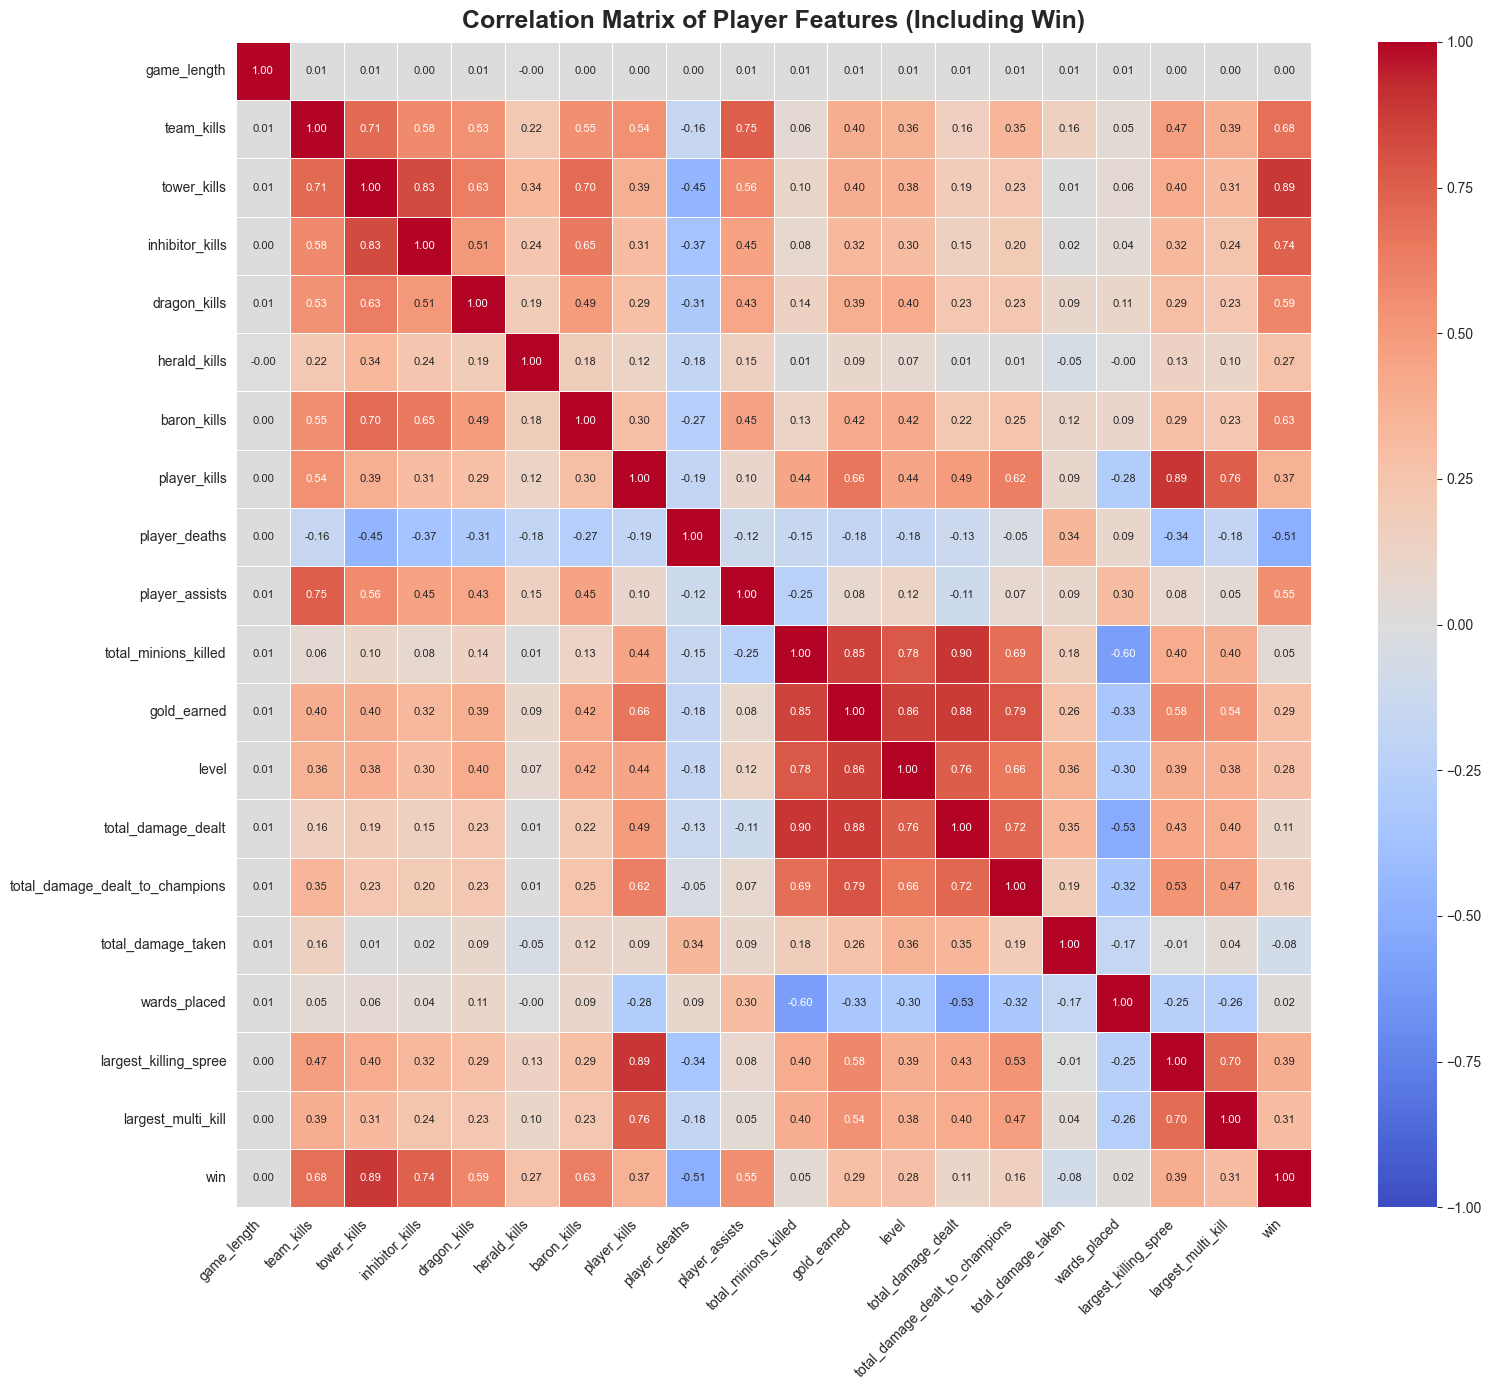

Correlations with winning:
win                                1.000000
tower_kills                        0.887931
inhibitor_kills                    0.743928
team_kills                         0.681768
baron_kills                        0.626854
dragon_kills                       0.589359
player_assists                     0.549323
largest_killing_spree              0.394062
player_kills                       0.368448
largest_multi_kill                 0.306146
gold_earned                        0.287535
level                              0.279079
herald_kills                       0.271070
total_damage_dealt_to_champions    0.162884
total_damage_dealt                 0.105298
total_minions_killed               0.047268
wards_placed                       0.018205
game_length                        0.000455
total_damage_taken                -0.083462
player_deaths                     -0.507776
Name: win, dtype: float64


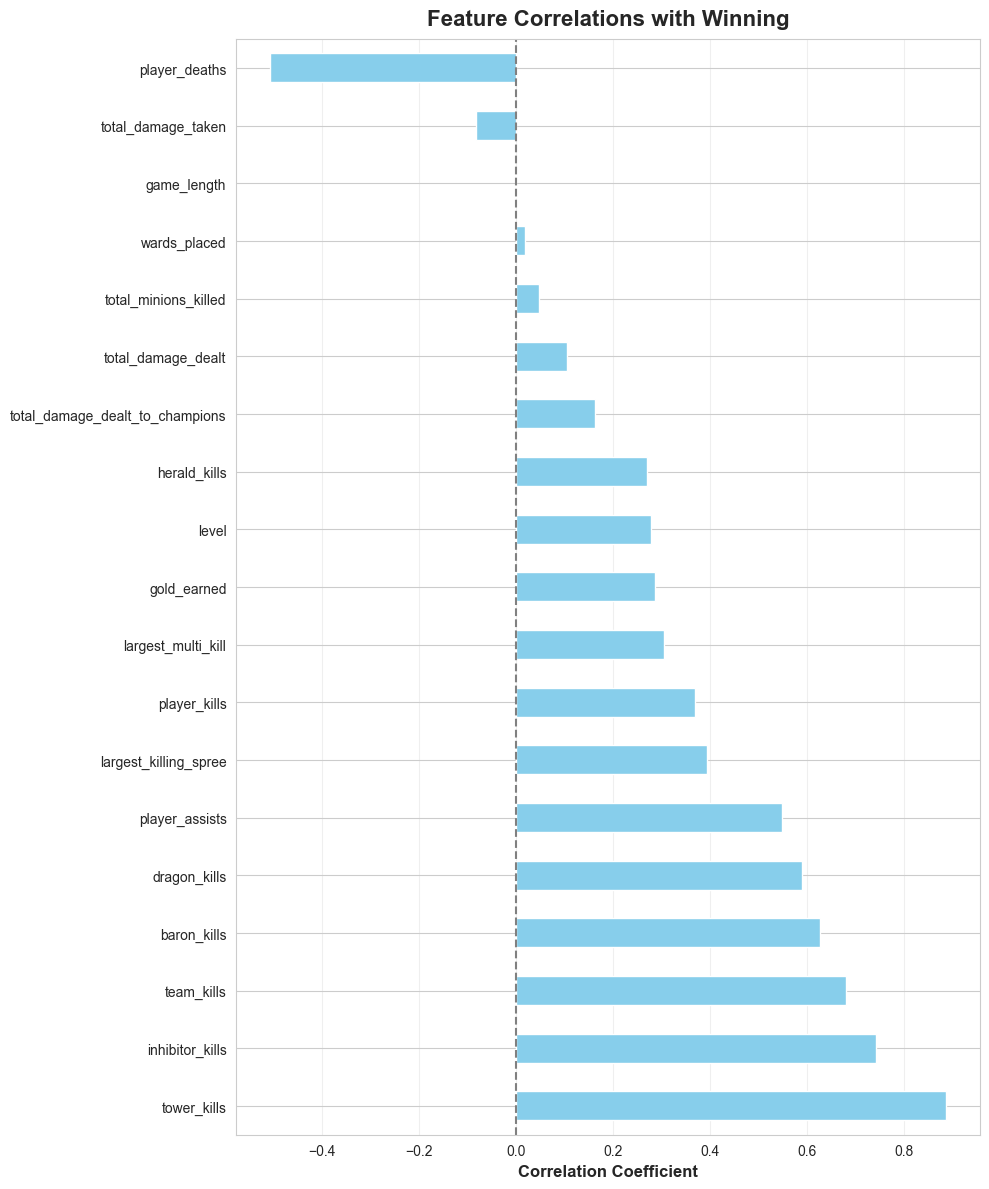

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select numeric columns from the original dataset
numeric_columns = df_game_players_stats.select_dtypes(include=['number']).columns.tolist()

# Exclude identifiers and non-feature columns but include 'win'
columns_to_exclude = ['game_id', 'player_id', 'team_id']
feature_columns = [col for col in numeric_columns if col not in columns_to_exclude]

# Make sure 'win' is included in feature_columns
if 'win' not in feature_columns:
    feature_columns.append('win')

# Calculate correlation matrix
correlation_matrix = df_game_players_stats[feature_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 14))

# Create a heatmap with seaborn
sns.heatmap(correlation_matrix, 
            annot=True,            # Show correlation values
            cmap='coolwarm',       # Blue-red color map
            linewidths=0.5,        # Add grid lines
            vmin=-1, vmax=1,       # Set limits for correlation values
            fmt='.2f',             # Format annotation with 2 decimal places
            annot_kws={"size": 8}) # Adjust annotation size for readability

# Add title
plt.title('Correlation Matrix of Player Features (Including Win)', fontsize=18)

# Improve readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

# Extract and display correlations with win specifically
win_correlations = correlation_matrix['win'].sort_values(ascending=False)

print("Correlations with winning:")
print(win_correlations)

# Create a horizontal bar plot for better visualization
plt.figure(figsize=(10, 12))
win_correlations.drop('win').plot(kind='barh', color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Feature Correlations with Winning', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Check data type

In [15]:
df_game_players_stats_filtered.info()

## non numeric columns do not need to be encoded they are not used in the model
## every used feature coluumn is complete (no missing values)
## No dupliactes in the dataset

 
## check for duplicates
duplicates = df_game_players_stats_filtered.duplicated().sum()
print(f"Number of duplicate records: {duplicates}")

<class 'pandas.core.frame.DataFrame'>
Index: 369774 entries, 0 to 374553
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   game_id                          369774 non-null  int64 
 1   player_id                        369774 non-null  int64 
 2   player_name                      369774 non-null  object
 3   team_id                          369774 non-null  int64 
 4   team_name                        369774 non-null  object
 5   team_acronym                     369579 non-null  object
 6   role                             369774 non-null  object
 7   win                              369774 non-null  bool  
 8   game_length                      369774 non-null  int64 
 9   champion_name                    369774 non-null  object
 10  team_kills                       369774 non-null  int64 
 11  tower_kills                      369774 non-null  int64 
 12  inhibitor_kills      

## Create and export final features

In [16]:
import os
from sklearn.preprocessing import MinMaxScaler
os.makedirs('../data/processed', exist_ok=True)

# Create a function to save the processed dataset
def processed_dataset():
    """
    Process the filtered dataset, calculate all derived features, and save to CSV.
    """
    # Start with the filtered dataset
    df_processed = df_game_players_stats_filtered.copy()
    
    # Add all the derived features we calculated
    df_processed['KLA'] = (df_processed['player_kills'] + df_processed['player_assists']) / (df_processed['player_deaths'] + 1)
    df_processed['gold_pm'] = df_processed['gold_earned'] / df_processed['game_length'] 
    df_processed['lvl_pm'] = df_processed['level'] / df_processed['game_length']
    df_processed['creep_score_pm'] = df_processed['total_minions_killed'] / df_processed['game_length']
    df_processed['wards_pm'] = df_processed['wards_placed'] / df_processed['game_length']
    
    df_processed['damage_pm'] = df_processed['total_damage_dealt'] / df_processed['game_length']
    df_processed['damage_to_champions_pm'] = df_processed['total_damage_dealt_to_champions'] / df_processed['game_length']
    df_processed['damage_taken_pm'] = df_processed['total_damage_taken'] / df_processed['game_length']
    
    df_processed['greatest_killing_spree'] = df_processed['largest_killing_spree']
    df_processed['greatest_multi_kill'] = df_processed['largest_multi_kill']

    return df_processed

# Save the processed dataset
processed_df = processed_dataset()

# Reorder columns to put identifiers first
cols = ['game_id', 'player_id', 'player_name', 'team_id', 'team_name', 'game_length', 'role', 'champion_name', 'win'] + game_players_input_features
processed_df = processed_df[cols]
print(processed_df.columns.tolist())

# Save normalized features
processed_df.to_csv('../data/processed/game_players_processed_features.csv', index=False)
print("- ../data/processed/game_players_processed_features.csv (processed features)")


# Select features for global normalization
df_normalized_all = processed_df[game_players_input_features]

# Fit the scaler on the feature data
scaler = MinMaxScaler()
scaler.fit(df_normalized_all)

# Transform the features
df_normalized_all = scaler.transform(df_normalized_all)

# Create a DataFrame with the normalized features
df_normalized = pd.DataFrame(df_normalized_all, columns=game_players_input_features)

# Add back the identifier columns
df_normalized['player_name'] = processed_df['player_name'].values
df_normalized['team_id'] = processed_df['team_id'].values
df_normalized['team_name'] = processed_df['team_name'].values
df_normalized['game_length'] = processed_df['game_length'].values
df_normalized['game_id'] = processed_df['game_id'].values
df_normalized['player_id'] = processed_df['player_id'].values
df_normalized['role'] = processed_df['role'].values
df_normalized['champion_name'] = processed_df['champion_name'].values
df_normalized['win'] = processed_df['win'].values

# Reorder columns to put identifiers first
df_normalized = df_normalized[cols]

# Save normalized features
df_normalized.to_csv('../data/processed/game_players_normalized_features.csv', index=False)
print("- ../data/processed/game_players_normalized_features.csv (normalized features)")

['game_id', 'player_id', 'player_name', 'team_id', 'team_name', 'game_length', 'role', 'champion_name', 'win', 'KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm', 'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm', 'greatest_killing_spree', 'greatest_multi_kill']
- ../data/processed/game_players_processed_features.csv (processed features)
- ../data/processed/game_players_normalized_features.csv (normalized features)


## Plot correlation matrix of the processed features

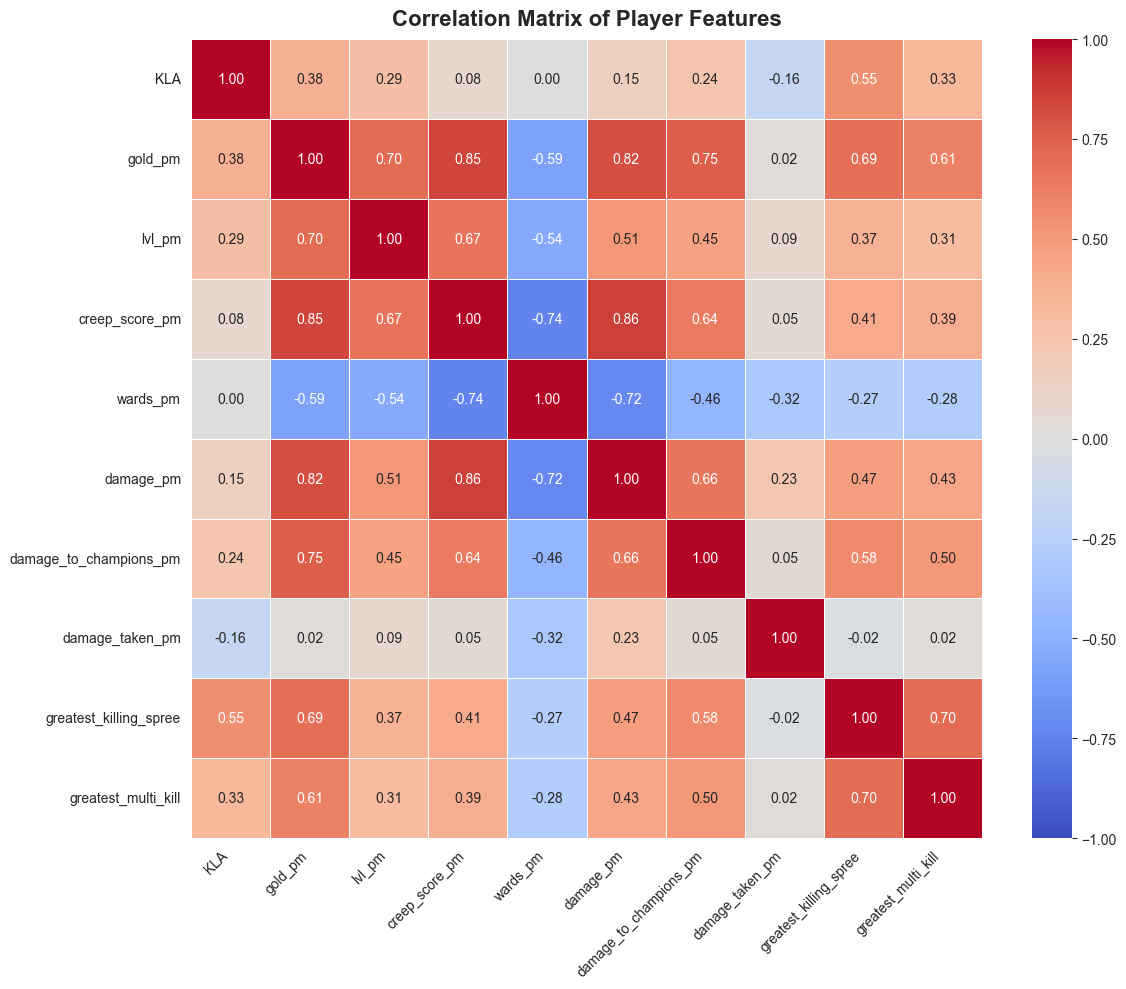

Top 5 highest feature correlations:
creep_score_pm and damage_pm: 0.86
damage_pm and creep_score_pm: 0.86
creep_score_pm and gold_pm: 0.85
gold_pm and creep_score_pm: 0.85
damage_pm and gold_pm: 0.82


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix of the input features
# Use the processed dataframe with your features
correlation_matrix = processed_df[game_players_input_features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with seaborn
sns.heatmap(correlation_matrix, 
            annot=True,            # Show correlation values
            cmap='coolwarm',       # Blue-red color map
            linewidths=0.5,        # Add grid lines
            vmin=-1, vmax=1,       # Set limits for correlation values
            fmt='.2f')             # Format annotation with 2 decimal places

# Add title
plt.title('Correlation Matrix of Player Features', fontsize=16)

# Improve readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Identify the highest correlations (excluding self-correlations)
# Get the absolute correlation values, set self-correlations to 0
corr_abs = correlation_matrix.abs()
np.fill_diagonal(corr_abs.values, 0)

# Find the top 5 most correlated feature pairs
s = corr_abs.unstack()
top5_corr = s.sort_values(ascending=False)[:5]

print("Top 5 highest feature correlations:")
for idx, val in top5_corr.items():
    print(f"{idx[0]} and {idx[1]}: {correlation_matrix.loc[idx[0], idx[1]]:.2f}")